<img align="left" src="logouniandes.png" alt="drawing" width="400"/>

<p align="rigth">  Proyecto 2 Machine Learning 
    
<p align="rigth"> Nombre: Thomas Grange
    
<p align="rigth">  Código: 202015791 </p>

## Introducción

Este ensayo intentará proponer diferentes modelos para clasificar los estados de sueño, basados en los datos recogidos por electrodos en sujetos voluntarios.

La presentación se dividirá en 3 partes :

* Analyse des données
* Extracción de características a mano para clasificar
* Clasificación con una red profunda

## 1. Presentación del Dataset

Importando bibliotecas, usaremos keras como backend

In [1]:
import os
import pyedflib as pyedf
import numpy as np
import matplotlib.pyplot as ptl
import statistics as stat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import mne
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, metrics, neural_network
from sklearn.model_selection import train_test_split

Usar la librería pyedflib para leer datos. Cargamos los datos de 3 personas, para aumentar el número de datos. Además, las señales pueden diferir de un sujeto a otro. Por lo tanto, entrenar un modelo con un solo sujeto puede llevar a situaciones de overfitting: el modelo estará calibrado con demasiada precisión en una persona.

In [2]:
os.chdir('/home/grangeth/Bureau/Machine_Learning/Projet2')
# Lectura del archivo de estados de sueño (etiquetas)
st_FileHypEdf = pyedf.EdfReader("SC4001EC-Hypnogram.edf")
# Lectura de las señales s_SigNum señales con nombres v_Signal_Labels
st_FileEdf = pyedf.EdfReader("SC4001E0-PSG.edf")

#segundo sujeto
hyp2 = pyedf.EdfReader("SC4002EC-Hypnogram.edf")
sig2 = pyedf.EdfReader("SC4002E0-PSG.edf")
#tercero sujeto
hyp3 = pyedf.EdfReader("SC4011EH-Hypnogram.edf")
sig3 = pyedf.EdfReader("SC4011E0-PSG.edf")


Usando la biblioteca mne, sólo para mostrar y analizar el conjunto de datos

Extracting EDF parameters from /home/grangeth/Bureau/Machine_Learning/Projet2/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


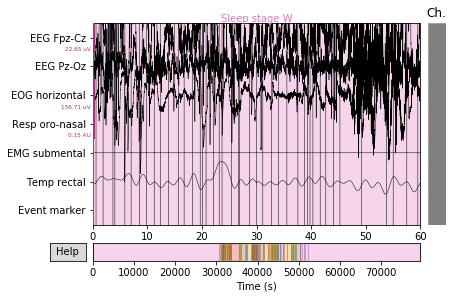

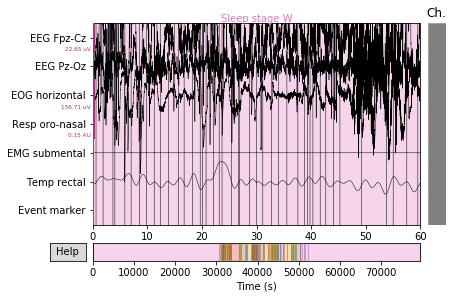

In [3]:
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

#mesclando el estado 3 y 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

#leer los archivos directamente con mne
raw = mne.io.read_raw_edf("SC4001E0-PSG.edf")
annot = mne.read_annotations("SC4001EC-Hypnogram.edf")

raw.set_annotations(annot, emit_warning=False)
raw.set_channel_types(mapping)

# display de algunos senales
raw.plot(duration=60, scalings='auto')




El conjunto de datos se compone de 7 canales por sujeto que corresponden a diferentes sensores, leemos los canales del archivo edf, y emitimos las etiquetas de hipnograma, con los estados de suma asociados a los canales.
Los canales fueron grabados a 100 Hz.

#### Distribución de los estados de sueños por epochs de 30 secundas

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


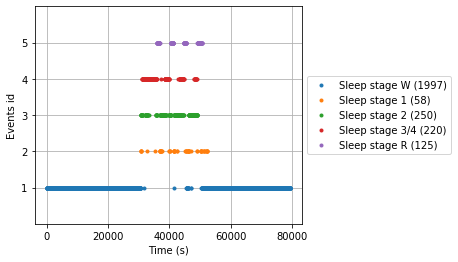

In [4]:
events, _ = mne.events_from_annotations(
    raw, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# plot events
mne.viz.plot_events(events, event_id=event_id,
                    sfreq=raw.info['sfreq'])

stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

El estado  despierto es el estado mayoritario, tenemos un conjunto de datos muy desequilibrado. Lo que se ha hecho para mostrar los estados es dividir los datos por epochs de 30 segundos, que es el enfoque que utilizaremos para organizar los datos en el código que figura a continuación.

In [5]:
def getEpochs(st_FileHypEdf, st_FileEdf, signals, epoLenght):
    epochs_data = {}
    for s_SigRef in signals:
        # Conversion a segundos usando frecuencia de muestreo.
        s_NSamples = st_FileEdf.getNSamples()[s_SigRef]
        s_FsHz = st_FileEdf.getSampleFrequency(s_SigRef)
        #print(s_NSamples)
        
        # v_Sig = np.zeros((s_NSamples, 1))
        v_Sig = st_FileEdf.readSignal(s_SigRef)
        s_WinSizeSam = np.round(s_FsHz * epoLenght)
        
        # Datos en ventanas de 30 segundos, 
        #v_HypTime es el tiempo de inicio, v_HypDur es la duración en un estado específico (pueden ser varias ventanas),
        # v_Hyp es la etiqueta.
        if(s_SigRef == max(signals)):
            v_HypTime, v_HypDur, v_Hyp = st_FileHypEdf.readAnnotations()
        
        # Guardar las señales 
        epochs_label = {}
        s_FirstInd = 0
        cont = 0
        for i in np.arange(0, s_NSamples/s_WinSizeSam):
            s_LastInd = s_FirstInd + s_WinSizeSam
            epochs_data[(s_SigRef,int(i))] = v_Sig[s_FirstInd:s_LastInd]
            if(s_SigRef == max(signals)):
                time = s_FirstInd / s_FsHz
                if(time >= v_HypTime[cont+1]):
                    cont = cont + 1
                epochs_label[int(i)] = v_Hyp[cont]
                
            s_FirstInd = s_LastInd
    epochs_label = pd.DataFrame.from_dict(epochs_label, orient = 'index',  columns = ['label'])
    return epochs_data, epochs_label

Arriba, dividimos los datos de un solo sujeto, según la época elegida en un Panda dataFrame, con las etiquetas asociadas a los estados.

In [6]:
def bandpower(data, epoLenght, chan):
    
    ts = epoLenght/len(data)                    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.fft(data))    # Get frequencies for amplitudes in Hz
    fft_freq  = np.fft.fftfreq(len(data), d = ts)
    
    # Define EEG bands
    eeg_bands = {'Chan'+str(chan)+' Delta': (0, 4),
                 'Chan'+str(chan)+' Theta': (4, 8),
                 'Chan'+str(chan)+' Alpha': (8, 12),
                 'Chan'+str(chan)+' Beta': (12, 30),
                 'Chan'+str(chan)+' Gamma': (30, 100)}
    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    
    
    return eeg_band_fft

Aquí extraemos las características útiles para sacar una tendencia en el estudio de las señales.
He elegido, entre otros, realizar, por épocas, la media de los datos en bruto, así como la varianza  y la banda de frecuencia.
Debido al gran número de canales, elegí trabajar sólo en los 3 primeros, para reducir el tiempo de cálculo.

In [7]:
def groupLabels(data, v_newLabels, v_oldLabels):
    # len(v_newLabels) = len(v_oldLabels)
    new_data = data
    for i in range(0,len(v_oldLabels)):
        boolVal = (data == v_oldLabels[i])
        new_data[boolVal] = v_newLabels[i]
    return new_data

def featuresExtraction(epochs_data,epoLenght,channels):
    #Index of epochs_data: epochs_data[('chanel',epoch)]
    
    X = {}
    fbp = pd.DataFrame()
    nrows = int(len(epochs_data)/len(channels))
    
    # Features for EEG signals (chan[0:2]): mean, var, EEG frecuency band
    for chan in channels[0:2]:
        mean = []
        var = []
        fbp_c = pd.DataFrame()
        for i in range(0,nrows):
            mean.append(stat.mean(epochs_data[(chan,i)]))
            var.append(stat.variance(epochs_data[(chan,i)]))
            fbp_c = fbp_c.append(bandpower(epochs_data[(chan,i)], epoLenght, chan), ignore_index = True)
        X[('mean','channel'+str(chan))] = mean
        X[('var','channel'+str(chan))] = var
        fbp = pd.concat([fbp,fbp_c],axis = 1)
        
    # Features for EOG signals (chan[2:3]): var
    for chan in channels[2:3]:
        var = []
        for i in range(0,nrows):
            var.append(stat.variance(epochs_data[(chan,i)]))
        X[('var','channel'+str(chan))] = var
    
    X = pd.DataFrame(X)
    X = pd.concat([X,fbp],axis = 1)
    return X

'===================================================  INSTRUCTIONS ==================================================='
winSize = 30 #Window size (seconds)
chan = range(0,3) #Channels to use in the model
data_split_epochs, data_label = getEpochs(st_FileHypEdf, st_FileEdf,chan,winSize)
Y = groupLabels(data_label,['Awake','Light sleep','Light sleep','Deep sleep','Deep sleep','REM sleep'],
                   ['Sleep stage W','Sleep stage 1','Sleep stage 2','Sleep stage 3','Sleep stage 4','Sleep stage R'])

X = featuresExtraction(data_split_epochs,winSize,chan)



In [8]:
#recojo los datos de un segundo sujeto
data_split_epochs2, data_label2 = getEpochs(hyp2, sig2,chan,winSize)
Y2 = groupLabels(data_label2,['Awake','Light sleep','Light sleep','Deep sleep','Deep sleep','REM sleep'],
                   ['Sleep stage W','Sleep stage 1','Sleep stage 2','Sleep stage 3','Sleep stage 4','Sleep stage R'])

X2 = featuresExtraction(data_split_epochs2,winSize,chan)

Para expandir mi conjunto de datos y diversificarlo, estoy recolectando datos de 3 sujetos diferentes. Los usaremos poco después.

In [9]:
#recojo los datos de un tercero sujeto
data_split_epochs3, data_label3 = getEpochs(hyp3, sig3,chan,winSize)
Y3 = groupLabels(data_label3,['Awake','Light sleep','Light sleep','Deep sleep','Deep sleep','REM sleep'],
                   ['Sleep stage W','Sleep stage 1','Sleep stage 2','Sleep stage 3','Sleep stage 4','Sleep stage R'])

X3 = featuresExtraction(data_split_epochs3,winSize,chan)

## Clasificación con características extrados a mano 

Con las características extraídas arriba, entrenaré diferentes modelos comparándolos, y notablemente cambiando los datos de entrada.
Primero clasificaré los estados de sueño con un algoritmo SVM, con un kernel lineal.

/home/grangeth/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

       Awake       0.99      0.99      0.99       647
  Deep sleep       0.88      0.92      0.90        71
 Light sleep       0.88      0.84      0.86       111
   REM sleep       0.85      0.87      0.86        46

    accuracy                           0.96       875
   macro avg       0.90      0.90      0.90       875
weighted avg       0.96      0.96      0.96       875


Confusion matrix:
[[643   1   2   1]
 [  0  65   6   0]
 [  4   8  93   6]
 [  1   0   5  40]]


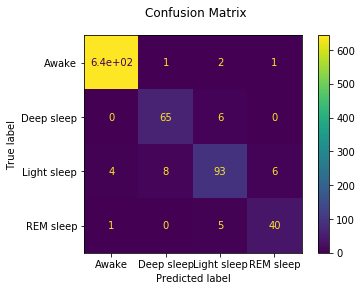

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.33, random_state=42)

'------SVM------'
clc_svm =  svm.SVC(kernel = 'linear',gamma=0.001)
clc_svm.fit(X_train, y_train)
sco_svm = clc_svm.score(X_test,y_test)
y_pred = clc_svm.predict(X_test)

metrics.confusion_matrix(y_test,y_pred)

print("Classification report for classifier %s:\n%s\n"
      % (clc_svm, metrics.classification_report(y_test, y_pred)))
disp = metrics.plot_confusion_matrix(clc_svm, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

Después de varias pruebas, es de hecho el núcleo lineal el que es más efectivo en esta situación
Para comparar, voy a entrenar un modelo de Random Forest con el mismo conjunto de datos, siempre con un solo sujeto.

In [11]:
# Creacion del model con 100 arboles
model = RandomForestClassifier(n_estimators=100, 
                               random_state=(50), 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit model con datos de entrenamiento
model.fit(X_train, y_train)

/home/grangeth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [12]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 109
Average maximum depth 10


In [13]:
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False):
              precision    recall  f1-score   support

       Awake       0.98      1.00      0.99       647
  Deep sleep       0.90      0.92      0.91        71
 Light sleep       0.87      0.83      0.85       111
   REM sleep       0.90      0.80      0.85        46

    accuracy                           0.96       875
   macro avg       0.91      0.89      0.90       875
weighted avg       0.96      0.96      

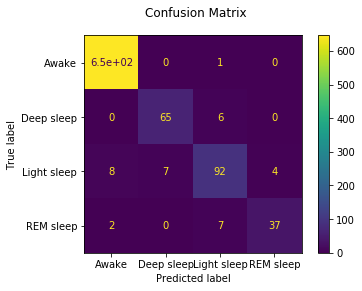

In [14]:
metrics.confusion_matrix(y_test,y_pred)

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test, rf_predictions)))
disp = metrics.plot_confusion_matrix(model, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

Los resultados son muy comparables con el SVM, ligeramente mejor con el random Forest. Sin embargo, estos resultados son muy buenos, demasiado buenos: entrenados y probados en el mismo sujeto. Así que voy a probar este modelo ya entrenado de SVM con datos de un segundo sujeto, ya que las señales pueden diferir de un sujeto a otro.

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

       Awake       0.96      0.98      0.97       636
  Deep sleep       0.94      0.84      0.88        91
 Light sleep       0.65      0.96      0.77       136
   REM sleep       0.00      0.00      0.00        71

    accuracy                           0.89       934
   macro avg       0.64      0.69      0.66       934
weighted avg       0.84      0.89      0.86       934


Confusion matrix:
[[626   0  10   0]
 [  1  76  14   0]
 [  2   4 130   0]
 [ 24   1  46   0]]


/home/grangeth/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


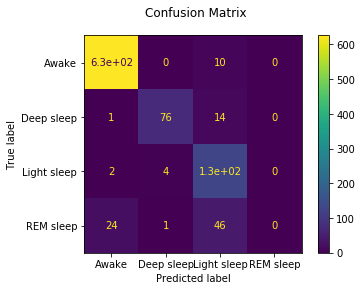

In [15]:
sco_svm2 = clc_svm.score(X_test2,y_test2)
y_pred2 = clc_svm.predict(X_test2)

metrics.confusion_matrix(y_test2,y_pred2)

print("Classification report for classifier %s:\n%s\n"
      % (clc_svm, metrics.classification_report(y_test2, y_pred2)))
disp = metrics.plot_confusion_matrix(clc_svm, X_test2, y_test2)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

De hecho, hay mucha confusión sobre el estado del REM. Para superar este problema, entrenaré un tercer modelo con datos de los sujetos 1 y 2, y lo probaré con datos del sujeto 3.

In [16]:
#creaccion de un conjunto de datos incluyendo los sujetos 1&2
frames = [X , X2]
framesy = [Y, Y2]
Xf = pd.concat(frames)
Yf = pd.concat(framesy)

X_trainf, X_testf, y_trainf, y_testf = train_test_split(Xf, Yf, test_size=0.33, random_state=42)


In [17]:

clc_svmf =  svm.SVC(kernel = 'linear',gamma=0.001)
clc_svmf.fit(X_trainf, y_trainf)


/home/grangeth/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

       Awake       0.95      0.96      0.96      1856
  Deep sleep       0.65      0.80      0.71       105
 Light sleep       0.83      0.87      0.85       671
   REM sleep       0.97      0.59      0.73       170

    accuracy                           0.91      2802
   macro avg       0.85      0.80      0.81      2802
weighted avg       0.91      0.91      0.91      2802


Confusion matrix:
[[1784   39   33    0]
 [   0   84   21    0]
 [  79    7  582    3]
 [   6    0   64  100]]


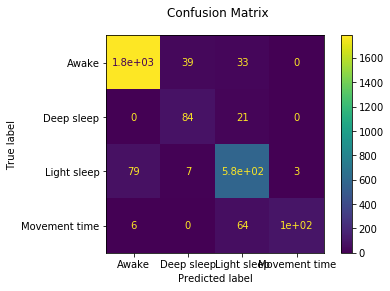

In [18]:
sco_svmf2 = clc_svmf.score(X3,Y3)
y_predf2 = clc_svmf.predict(X3)

metrics.confusion_matrix(Y3,y_predf2)

print("Classification report for classifier %s:\n%s\n"
      % (clc_svm, metrics.classification_report(Y3, y_predf2)))
disp = metrics.plot_confusion_matrix(clc_svmf, X3, Y3)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

Podemos ver que hubo un exceso de adaptación (overfitting) al entrenar el modelo con los datos de un solo paciente, siendo los rasgos aprendidos demasiado sensibles a las particularidades de un sujeto. Es mejor con más datos (especialmente en el sueño profundo, pasamos de 0% a 60%)pero sería aún mejor hacerlo con más datos, pero llevaría mucho más tiempo hacer los cálculos.

## Clasificación con una red profunda

Importación de las librerías:

In [19]:
from keras import optimizers, losses, activations, models
from keras import layers
from keras import Model
from keras import Sequential
from keras import losses
from keras_contrib.layers import CRF
from keras.layers import Input, Flatten,MaxPooling2D, Conv2D,Dense,Dropout, Embedding, LSTM, GRU, Input, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D,  concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM

Using TensorFlow backend.


Desafortunadamente, no pude encontrar el formato de vector apropiado, aceptado por el keras model_train.


Una red convolucional está compuesta por 4 capas principales, que pueden ser expandidas:

* Primera capa : Convolución: detecta características usando filtros de convolución, las características hacen filtros, cada una es definida por un kernel de convolución. La imagen se filtra con cada núcleo. La convolución entre un vector de datos y un filtro produce un mapa de activación o un mapa de características. La retropropagación sigue actualizando estas características.

* Segunda capa: Pooling: extrae el máximo local de los mapas de características. De esta manera se emite un mapa de características más pequeño, reduciendo el número de parámetros.

* Tercera capa: Activación: Activación de ReLu, que reemplaza todas las entradas negativas por ceros. Permite utilizar sólo una neurona a la vez, ahorrando tiempo de trabajo acumulativo. En la salida usaremos activación relu,más adecuado que el sigmoid para la clasificación de clases múltiples.

* Cuarta capa: Completamente conectada : En una capa completamente conectada, aplanamos la salida de la última capa de convección y conectamos cada nodo de la capa actual con el otro nodo de la siguiente capa. Las neuronas en una capa totalmente conectada tienen conexiones completas a todas las activaciones de la capa anterior.

Mi idea era dar los datos "en bruto", por épocas a una red CNN, establecida de la siguiente manera:

Para evitar que el modelo se sobreajuste al ruido, se aplica la regularización L2.
Uso del optimizador de Adam es que es robusto a la elección de los hiperparámetros hasta cierto punto  y por lo general funciona muy bien empíricamente, que es nuestro caso, la red tiene que buscar sus proprios parametros de clasifición.
A continuación se da un ejemplo de una red parecida a lo que expliqué.



In [20]:
def model():
    inp = Input(shape=X_cnn[0].shape)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.01)(img_1)

    dense_1 = Dropout(0.01)(Dense(64, activation=activations.relu, name="dense_1")(img_1))

    base_model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    base_model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    base_model.summary()
    return base_model


In [21]:
#print(data_split_epochs)
X_cnn = pd.DataFrame(data_split_epochs)
y_cnn = pd.DataFrame(data_label)
modelcnn =  model()

#X_tr, X_te, y_tr, y_te = train_test_split(X_cnn, y_cnn, test_size=0.33, random_state=42)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3000, 2650)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2996, 16)          212016    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2992, 16)          1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1496, 16)          0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1496, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1494, 32)          1568      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1492, 32)          3104

Con keras, es posible guardar los pesos asociados a cada clase, por lo que, con un vector adaptado a la red podría haber modificado el peso por ejemplo del "sueño profundo", con el método *model.load_weights.

Sin embargo, no lo logré, aunque pasé mucho tiempo buscando alternativas y soluciones.
Las alternativas, sin embargo, se hicieron con un conjunto de datos diferente, con entradas de csv, más fáciles de manejar. Sin embargo, esto elimina la dimensión de la gestión de datos, lo cual es muy interesante.


# Recursos: 


* Tensorflow Documentation : https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

* Fernando Lozano, Redes Neuronales, SVM, Kernels, Redes Profundas

* Automatic Sleep Stage Classification Based on Convolutional Neural Network and Fine-Grained Segments : https://www.hindawi.com/journals/complexity/2018/9248410/

* Implementing SVM and Kernel SVM with Python's Scikit-Learn : https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/

* Youness Mansar, Sleep Stage Classification from Single Channel EEG using Convolutional Neural Networks : https://towardsdatascience.com/sleep-stage-classification-from-single-channel-eeg-using-convolutional-neural-networks-5c710d92d38e
